In [1]:
from sklearn.cluster import KMeans

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_regression
from sklearn.neighbors import LocalOutlierFactor

from category_encoders import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

### Helpers

In [2]:
def make_clusters(df, col, y, n_cluster, merge=False):
    '''
        function to boil down a colum to n_cluster
        
        recive:
        
            df: a data frame 
            col: col to make cluster
            y: the response variable
            n_cluster: stamitation of number of cluster
            
        return:  
            a data frame with 'col' droped, and 'col' + '_cluster' column
            is added to the data frame

        
    '''
    col_clusters = KMeans(n_clusters=n_cluster, random_state=777)

    # 'Neighborhood' and 'MSSubClass' stats
    col_stats = df.groupby(col)[y].describe()

    # Getting clusters
    col_clusters.fit(col_stats)

    # preparing DF with cluster lables to merge
    new_name = col + '_Cluster'
    col_cluster_df = pd.DataFrame( { col: col_stats.index.to_list(),
                                     new_name: col_clusters.labels_.tolist()} )
    
    if merge:
        # merging the clusters with the data frame
        df = df.merge(col_cluster_df, how='left', on=col)

        df[new_name] = df[new_name].astype(str)
        
        result = df.drop(columns=col)
        
    else:
        result = col_cluster_df
    
    return result.copy()


# Low frequency categories to 'Other'
def lower_than(df, col, percentage):
    ''' function that will merge low frequency classes into 
        a single class 'Others'

        parameters:
            df: a DataFrame
            col: column's name to work on
            percentage(%): the threshold like 0.1, 0.2

        returns:
            df: the data frame with col's classes that are lowers
                than 'threshold' been repleced with 'Other' category
    '''

    # calculating the column frequency
    col_freq = df[col].value_counts(normalize=True)

    # the getting the column threshold 
    threshold = col_freq.quantile(q= percentage)

    # knowing the classes that are below the threshold
    less_freq_classes = col_freq[ col_freq <= threshold ]

    others = less_freq_classes.index.to_list()

    print(others)

    df[col] = df[col].replace(others, 'Others')

    return df


### Data

In [3]:
def data(verbose=False):
    
    d_tr = pd.read_csv('/Users/antirrabia/Documents/01-GitHub/DataMining-_-/CSV/HousePrices/train.csv', index_col='Id')
    d_te = pd.read_csv('/Users/antirrabia/Documents/01-GitHub/DataMining-_-/CSV/HousePrices/test.csv', index_col='Id')
    
    # Utilities has just 2 categories, and one of them
    # just appears once so we delete the whole column.
    d_tr = d_tr.drop(columns='Utilities')
    d_te = d_te.drop(columns='Utilities')
    
    # Marking Training Set
    d_tr['Training'] = True
    d_te['Training'] = False  
    
    if(verbose):
        print('d_tr shape:', d_tr.shape)
        print('d_te shape:', d_te.shape)
        
    return (d_tr.copy(), d_te.copy())
    

### Analazy 'Y'('SalePrice')

In [4]:
def analyze_y(df, verbose=False):
    
    
    df = df.copy()
    
    # Plotting
    if(verbose):
        fg, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(11,7))
        # chequing the distribution of 'y' = 'SalePrice'
        
        sns.histplot( df['SalePrice'], bins=50, ax= ax1);
        ax1.title.set_text('Skewed SalePrice')
    
        sns.scatterplot(x=df['GrLivArea'], y=df['SalePrice'], ax=ax3);
        ax3.title.set_text('Outliers')
    
    outliers = df[ df['GrLivArea'] >= 4500].index
    
    # deleting the outliers in 'GrLivArea'
    df.drop(outliers, inplace=True)
    
    # Plotting
    if(verbose):
        # cheking again
        sns.scatterplot(x=df['GrLivArea'], y=df['SalePrice'], ax=ax4);
        ax4.title.set_text('NO Outliers')
    
    # pipeline to scale and do a powerTransforme on y('SalePrice')
    fix_y = Pipeline([('scaler', RobustScaler()), ('power', PowerTransformer(method='yeo-johnson'))])
    
    y = fix_y.fit_transform( df['SalePrice'].values.reshape(-1, 1) )
    
    # Plotting
    if(verbose):
        # checking the distribution of 'y' again
        sns.histplot(y, bins=50, ax=ax2);
        ax2.title.set_text('yeo-johnson transformed \'y\'')
        
        plt.tight_layout()
        plt.show()
        
    # if(verbose):
    print('droped index: \n', outliers)
        
    df['SalePrice'] = y.copy()
    
    return df.copy()
    

### Combining training and test sets

In [5]:
def combine_tr_te(df_tr, df_te, verbose=False):
    
    all_d = pd.concat([d_tr.copy(), d_te.copy()])
    
    if(verbose):
        print('New data shape: ', all_d.shape)
        
    return all_d.copy()

### Imputting 'nan'

In [6]:

def impute_nan(all_data):
    
    # 34 columns with nan
    def fillWithNone(df):
        ''' nan in 'PoolQC' means 'no pool' 
            nan in 'MiscFeature' means 'no misc feature'
            nan in 'Alley' means 'no alley acces'
            nan in 'Fence' means 'no fence'
            nan in 'FireplaceQu' means 'no Fireplace'
            nan in 'GarageType', 'GarageFinish', 'GarageQual',
                'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1'
                'BsmtFinType1', 'MasVnrType', 'MSSubClass'
                'GarageCond' replaced with 'None' too

            recive a df
        '''

        df = df.copy()

        columns = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 
                   'FireplaceQu', 'GarageType', 'GarageFinish', 
                   'GarageQual', 'GarageCond', 'BsmtQual',
                   'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                   'BsmtFinType2', 'MasVnrType'
                  ]

        for col in columns:
            df[col] = df[col].fillna('None')

        return df

    def fillWithZero(df):
        ''' nan 

        '''

        df = df.copy()

        columns = ['GarageYrBlt', 'GarageArea', 'GarageCars',
                   'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                   'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
                   'MasVnrArea'
                  ]

        for col in columns:
            df[col] = df[col].fillna(0)

        return df

    def fillWithMode(df):
        ''' fill missing values with mode, median
        '''
        df = df.copy()

        columns = ['Electrical', 'KitchenQual', 'Exterior1st',
                   'Exterior2nd', 'SaleType'
                  ]

        for col in columns:
            df[col] = df[col].fillna(df[col].mode()[0])

        # filling with median of each 'Neighborhood'
        df['LotFrontage'] = (
                         df.groupby('Neighborhood')['LotFrontage']
                         .transform(lambda x: x.fillna(x.median()))
                        )  

        # nan means Typical
        df['Functional'] = df['Functional'].fillna('Typ')

        return df


    def mszoning(df):
        ''' recives a DF this imputation takes place on test data only'''

        df = df.copy()

        idotrr = ( (df['Neighborhood'] == 'IDOTRR') & (df['MSZoning'].isna()) )
        mitchel = ( (df['Neighborhood'] == 'Mitchel') & (df['MSZoning'].isna()) )

        df.loc[ idotrr , 'MSZoning'] = 'RM'
        df.loc[ mitchel, 'MSZoning'] = 'RL'

    #     # to test this function out of here
    #     temp = mszoning(d_te)
    #     # lable index acces at [1916, 2217, 2251, 2905
    #     temp.loc[[1916, 2217, 2251, 2905], 'MSZoning']

        return df

    none_func = FunctionTransformer(fillWithNone, validate=False) 
    zero_func = FunctionTransformer(fillWithZero, validate=False) 
    mode_func = FunctionTransformer(fillWithMode, validate=False)
    mszo_func = FunctionTransformer(mszoning, validate=False)
    
    
    imputer = Pipeline([
                    ('withNone', none_func), 
                    ('withZero', zero_func), 
                    ('withMode', mode_func), 
                    ('mszoni', mszo_func)
                   ])
    
    result = imputer.fit_transform(all_data)
    
    return result.copy()

### Reduce Categories(Collapsing)

In [7]:
def reduce_categories(all_data):
    '''
    '''


    con1_others = ['RRAn', 'PosN', 'RRAe', 'PosA', 'RRNn', 'RRNe']
    roofS_others = ['Gambrel', 'Flat', 'Mansard', 'Shed']
    foun_others = ['Slab', 'Stone', 'Wood']
    gara_others = ['None', 'Basment', '2Types', 'CarPort']
    saleT_others = ['ConLD', 'CWD', 'ConLI', 'ConLw', 'Oth', 'Con']
    saleC_others = ['Family', 'Alloca', 'AdjLand']
    exte1_others = ['BrkComm', 'AsphShn', 'Stone', 'CBlock', 'ImStucc']
    exte2_others = ['BrkComm', 'AsphShn', 'Stone', 'CBlock', 'ImStucc', 'Other']
    lotC_others = ['FR2', 'FR3']

    all_data['Condition1'] = all_data['Condition1'].map(lambda x: 'Others' if x in con1_others else x)
    all_data['RoofStyle'] = all_data['RoofStyle'].map(lambda x: 'Others' if x in roofS_others else x)
    all_data['Foundation'] = all_data['Foundation'].map(lambda x: 'Others' if x in foun_others else x)
    all_data['GarageType'] = all_data['GarageType'].map(lambda x: 'Others' if x in gara_others else x)
    all_data['SaleType'] = all_data['SaleType'].map(lambda x: 'Others' if x in saleT_others else x)
    all_data['SaleCondition'] = all_data['SaleCondition'].map(lambda x: 'Others' if x in saleC_others else x)
    all_data['Exterior1st'] = all_data['Exterior1st'].map(lambda x: 'Others' if x in exte1_others else x)
    all_data['Exterior2nd'] = all_data['Exterior2nd'].map(lambda x: 'Others' if x in exte2_others else x)
    all_data['LotConfig'] = all_data['LotConfig'].map(lambda x: 'Others' if x in lotC_others else x)


    # Reducing to a BINARY CLASSES(just 2 clases)

    landC_others = ['HLS', 'Bnk', 'Low']
    cond2_others = ['Feedr', 'Artery', 'PosN', 'PosA', 'RRNn', 'RRAn', 'RRAe']
    roofM_others = ['Tar&Grv', 'WdShake', 'WdShngl', 'Metal', 'Membran', 'Roll', 'ClyTile']
    heati_others = ['GasW', 'Grav', 'Wall', 'OthW', 'Floor']
    elect_others = ['FuseA', 'FuseF', 'FuseP', 'Mix']
    miscF_others = ['Shed', 'Gar2', 'Othr', 'TenC']

    all_data['LandContour'] = all_data['LandContour'].map(lambda x: 'Others' if x in landC_others else x)
    all_data['Condition2'] = all_data['Condition2'].map(lambda x: 'Others' if x in cond2_others else x)
    all_data['RoofMatl'] = all_data['RoofMatl'].map(lambda x: 'Others' if x in roofM_others else x)
    all_data['Heating'] = all_data['Heating'].map(lambda x: 'Others' if x in heati_others else x)
    all_data['Electrical'] = all_data['Electrical'].map(lambda x: 'Others' if x in elect_others else x)

    all_data['MiscFeature'] = all_data['MiscFeature'].map(lambda x: 'Others' if x in miscF_others else x)
    
    
    return all_data.copy()

### Features Engineering

In [8]:

def features_engineering(all_data):
    # Before using d_tr set 
    # get the new d_tr set from all_data
    d_tr = all_data[all_data['Training']].copy()

    # Creating a new feature 'PeakMonths', 'Unfinished',
    # 'Splited', and TotalSF
    peak_moS = [5, 6, 7]
    unfi_hou = ['1.5Unf', '2.5Unf']
    spli_hou = ['SFoyer', 'SLvl']

    all_data['PeakMonths'] = all_data['MoSold'].map(lambda x: 'Peak' if x in peak_moS else 'Normal' )
    all_data['Finished']   = all_data['HouseStyle'].map(lambda x: 'no' if x in unfi_hou else 'yes') 
    all_data['Splited']    = all_data['HouseStyle'].map(lambda x: 'yes' if x in spli_hou else 'no')

    all_data['TotalSF']    = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

    
    # ======== Clustering ==========
    # we will use the training data because if we uses all_data
    # it has 'nan' in 'SalePrice'. test data does not have 'SalePrice'
    # 'Neighborhood', 5, 'MSSubClass', 4
    nei_cluster = make_clusters(d_tr.copy(), 'Neighborhood', 'SalePrice', 5)
    mss_cluster = make_clusters(d_tr.copy(), 'MSSubClass', 'SalePrice', 4)

    # merging the clusters data frame with all_data DataFrame
    # we got a 'nan' cluster becouse 'MSSubClass' in test_DF
    # has a '150' class that is just in test
    # we preserved the index from all_d DF
    all_data = all_data.reset_index().merge(nei_cluster, how='left', on='Neighborhood').set_index('Id')
    # all_data.drop(columns='Neighborhood', inplace=True)

    all_data = all_data.reset_index().merge(mss_cluster, how='left', on='MSSubClass').set_index('Id')
    
    # dropping old columns
    # all_data.drop(columns=['Neighborhood', 'MSSubClass'], inplace=True)

    # all_data.reset_index(drop=True, inplace=True)
    
    # ========= Cycling Features ====
    all_data[ 'MoSold' + '_sin'] = np.sin( all_data['MoSold'] * (2.*np.pi/12) )
    all_data[ 'MoSold' + '_cos'] = np.cos( all_data['MoSold'] * (2.*np.pi/12) )
    
    # ========= Cleaning ============
    all_data.drop(columns=['Neighborhood', 'MSSubClass', 'MoSold'], inplace=True)
    
    # updating the ** new feature ** types
    all_data = all_data.astype( {'PeakMonths':str, 'Finished':str, 'Splited':str,
                                 'Neighborhood_Cluster': str, 'MSSubClass_Cluster': str} )#,
                                 # 'MoSold_sin': str, 'MoSold_cos': str } )
    
    return all_data.copy()

# # updating cat_to_1Hot
# cat_to_1Hot.update( {'PeakMonths':str, 'Finished':str, 'Splited':str,
#                        'Neighborhood_Cluster': str, 'MSSubClass_Cluster': str} )

### Global Variables
> ord_cat_mapping  
> cat_to_1Hot  
> ord_cat_DONE  

In [23]:
##### ****** All writed by me ****** #####
##########################################
def get_global_variables():
    ord_cat_mapping = [
        {
            'col': 'FireplaceQu',
            'mapping': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
        },
        {
            'col': 'GarageQual',
            'mapping': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
        },
        {
            'col': 'GarageCond',
            'mapping': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
        },
        {
            'col': 'BsmtFinType1',
            'mapping': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
        },
        {
            'col': 'BsmtFinType2',
            'mapping': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
        },
        {
            'col': 'ExterQual',
            'mapping': {'Fa': 0, 'TA': 1, 'Gd': 2, 'Ex': 3}
        },
        {
            'col': 'ExterCond',
            'mapping': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
        },
        {
            'col': 'BsmtQual',
            'mapping': {'None': 0 , 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
        },
        {
            'col': 'BsmtCond',
            'mapping': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4}
        },
        {
            'col': 'PoolQC',
            'mapping': {'None': 0, 'Fa': 1, 'Gd': 2, 'Ex': 3}
        },
        {
            'col': 'HeatingQC',
            'mapping': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
        },
        {
            'col': 'KitchenQual',
            'mapping': {'Fa': 0, 'TA': 1, 'Gd': 2, 'Ex': 3}
        },
        {
            'col': 'BsmtExposure',
            'mapping': {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
        },
        {
            'col': 'Functional',
            'mapping': {'Sev': 0, 'Maj2': 1, 'Maj1': 2, 'Mod': 3, 'Min2': 4, 'Min1': 5, 'Typ': 6}
        },
        {
            'col': 'GarageFinish',
            'mapping': {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
        },
        {
            'col': 'Fence',
            'mapping': {'None': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}
        },
        {
            'col': 'CentralAir',
            'mapping': {'N': 0, 'Y': 1}
        },
        {
            'col': 'PavedDrive',
            'mapping': {'N': 0, 'P': 1, 'Y': 2}
        },
        {
            'col': 'Street',
            'mapping': {'Grvl': 0, 'Pave': 1}
        },
        {
            'col': 'Alley',
            'mapping': {'None': 0, 'Grvl': 1, 'Pave': 2}
        },
        {
            'col': 'LandSlope',
            'mapping': {'Gtl': 0, 'Mod': 1, 'Sev': 2}
        },
        {
            'col': 'LotShape',
            'mapping': {'Reg': 0, 'IR1': 1, 'IR2': 2, 'IR3': 3}
        },
        {
            'col': 'HouseStyle', 
            'mapping': {'SLvl': 0, 'SFoyer': 0, '1Story': 1, '1.5Fin': 2, 
                        '1.5Unf': 2, '2Story': 3, '2.5Unf': 4, '2.5Fin': 4}
        }
    ]

    # list of categorical columns(23)  
    # that we just encoded
    ord_cat_DONE = {'FireplaceQu': str, 'GarageQual': str,'GarageCond': str,'BsmtFinType1': str,
                     'BsmtFinType2': str,'ExterQual': str,'ExterCond': str,'BsmtQual': str,
                     'BsmtCond': str,'PoolQC': str,'HeatingQC': str,'KitchenQual': str,
                     'BsmtExposure': str,'Functional': str,'GarageFinish': str,'Fence': str, 
                     'CentralAir': str, 'PavedDrive': str,'Street': str,'Alley': str,
                     'LandSlope': str,'LotShape': str, 'HouseStyle': str}

    # to encode using OneHot (15 so far)
    cat_to_1Hot = {'Condition1': str, 'RoofStyle': str, 'Foundation': str, 'GarageType': str, 'SaleType': str, 
                   'SaleCondition': str, 'Exterior1st': str, 'Exterior2nd': str, 'LotConfig': str, 'LandContour': str, 
                   'Condition2': str, 'RoofMatl': str, 'Heating': str, 'Electrical': str, 'MiscFeature': str }

    # updating cat_to_1Hot with new created features
    cat_to_1Hot.update( {'PeakMonths':str, 'Finished':str, 'Splited':str,
                           'Neighborhood_Cluster': str, 'MSSubClass_Cluster': str} )

    # updating the types
    # update the list of ordinal with 2 columns name
    # that allredy are ordinal and encoded ('OverallQual', 'OverallCond')

    ord_cat_DONE.update({'OverallQual': str, 'OverallCond': str})#,
                         # 'MoSold_sin': str, 'MoSold_cos': str})
    # new_d = new_d.astype(ord_cat_DONE)

    # 5 more columns will concidere as categorical
    # we take off 'MoSold': str, 
    cat_to_1Hot.update({'YrSold': str, 'BldgType':str, 
                        'MSZoning': str, 'MasVnrType': str})

    # new_d = new_d.astype(cat_to_1Hot)
    
    # updating the data type
    # df = df.astype(cat_to_1Hot)
    # df = df.astype(ord_cat_DONE)
    
    return (ord_cat_mapping, ord_cat_DONE, cat_to_1Hot)

### Ordinal and OneHot encoding

In [10]:
def ordinal_1hot_encode(all_data, ord_mapping, oneHot_col):
    
    ## OrdinalEncoder
    oe = OrdinalEncoder(mapping=ord_mapping).fit(all_data)
    
    all_data = oe.transform(all_data)
    
    
    ## OneHot encoding
    oh = OneHotEncoder(cols=oneHot_col).fit(all_data)
    
    all_data = oh.transform(all_data.copy())
    
    
    
    return all_data.copy()

### Feature Selection

In [11]:
def feature_selection(X, y, verbose=False, sorted_features=False):
    
    mutual_info = mutual_info_regression(X=X, y=y)
    
    mu_info_df = pd.DataFrame(list(zip( X.columns, mutual_info )), columns=['Features', 'Mutual_info'])
    
    feature_to_dop = mu_info_df[ mu_info_df['Mutual_info'] == 0]
    feature_to_dop = list( feature_to_dop['Features'] )
    
    if(verbose):
        #Sorting
        # mu_info_df.sort_values('Mutual_info', ascending=False, inplace=True)
        print('{} Features with Zero(0) mutual info: \n'.format(len(feature_to_dop)))
        feature_to_dop = sorted(feature_to_dop)
        print(feature_to_dop)
        
    if( (verbose == False) and sorted_features):
        feature_to_dop = sorted(feature_to_dop)
        
    
    return (feature_to_dop, mu_info_df.sort_values('Mutual_info', ascending=False).copy() )

### Fix skewed columns

In [12]:
def fix_skew_cols(df, cols, treshold=0.7):
    '''
    this function scals and fix the skewed columns
    by applying RobustScaler() and 'yeo-johnson' transform
    '''
    
    skewed = all_d[cols].skew()
    
    skewed = skewed[skewed >= 0.7]
    skewed = skewed.index
    
    print('{} features with skewe >= {}'.format( len(skewed), treshold ) )
    
    fix_data_skew = Pipeline([('scaler', RobustScaler()), 
                          ('yeo', PowerTransformer(method='yeo-johnson'))])
    
    df[skewed] = fix_data_skew.fit_transform(df[skewed].copy())
    
    return df.copy()

### Polynomial Features

In [13]:
def poly_features(df, top_cols):
    '''
    function to create the interaction feature of the top_cols
    
    '''
    
    top_cols_set = df[top_cols].copy()
    # top_cols_set
    
    poly_features = PolynomialFeatures(2, interaction_only=True, include_bias=False)
    
    index_backup = top_cols_set.index.copy()
    
    poly_set = pd.DataFrame( poly_features.fit_transform(top_cols_set.copy()), columns=poly_features.get_feature_names_out(top_cols) )
    poly_set.set_index(index_backup, inplace=True)
    # poly_set
    
    poly_set.drop(columns=top_cols, inplace=True)
    # poly_set
    
    result = df.merge(poly_set, left_index=True, right_index=True)
    
    return result.copy()
    

# Driver

In [14]:
# get the data
d_tr, d_te = data(verbose=True)

d_tr shape: (1460, 80)
d_te shape: (1459, 79)


In [15]:
# taking cara of some outliers
# and making 'y' more gausian like
d_tr = analyze_y(d_tr.copy())

droped index: 
 Int64Index([524, 1299], dtype='int64', name='Id')


In [16]:
# after take care of some outlier
# combine the training and the test
all_d = combine_tr_te(d_tr.copy(), d_te.copy(), verbose=True)
all_d.shape

New data shape:  (2917, 80)


(2917, 80)

### Imputing

In [17]:
# imputing nan
all_d = impute_nan(all_d.copy())

In [18]:
all_d.columns[all_d.isna().any()].to_list()

['SalePrice']

### Reducing Cardinality

In [19]:
# reducing the number of categories in some columns
all_d = reduce_categories(all_d.copy())
# all_d['Foundation'].value_counts()

### Feature Engineering

In [20]:
# Creating a new feature 'PeakMonths', 'Unfinished',
# 'Splited', and TotalSF, and Clusters 
# transforming cyclical feature 'MoSold'
all_d = features_engineering(all_d.copy())

### Identifying  
> Categorical and Number Columns

In [25]:
# getting the global variables
ord_cat_mapping, ord_cat_DONE, cat_to_1Hot = get_global_variables()

In [26]:
# updating the data type
all_d = all_d.astype(cat_to_1Hot)
all_d = all_d.astype(ord_cat_DONE)

In [27]:
# after updating all the categorical columns
# we can now identify the number columns
numbers_col = all_d.select_dtypes('number')
numbers_col = numbers_col.columns.to_list()

# removing the transformed cyclical feature
# that already are float and we dont want to
# touch them
numbers_col.remove('MoSold_sin')
numbers_col.remove('MoSold_cos')
# MoSold_sin, MoSold_cos

In [ ]:
analyzed_col = numbers_col + list(cat_to_1Hot.keys()) + list(ord_cat_DONE.keys())
set( all_d.columns.to_list() ) - set( analyzed_col )

In [ ]:
set( analyzed_col ) - set( all_d.columns.to_list() )

In [ ]:
print('analyzed_col len:', len(analyzed_col))
print('all_d.columns len', len(all_d.columns.to_list()))

### Fixing skewnnes on Number Columns

In [ ]:
# the DF returned will have numbers_col Scalered and 
# PowerTransformed
all_d = fix_skew_cols(all_d.copy(), numbers_col) # this function keeps the index

### Doing Ordinal and OneHot Encoding

In [ ]:
# encoding ordinal and onehot columns( keeps Id index)
all_d = ordinal_1hot_encode(all_d.copy(), ord_cat_mapping, cat_to_1Hot)

In [ ]:
all_d

### Feature Selection

In [ ]:
# getting the training set to work with
d_tr = all_d[ all_d['Training'] ].copy()

In [ ]:
# we will get the features that has 0 mutual information with 'y'
# and a DF with **ALL the features** with their mutual info value
# from it we can get the top ones, to do polynomial interaction
to_drop, mutual_info_df = feature_selection( d_tr.drop(columns='SalePrice').copy(), d_tr['SalePrice'].copy(), verbose=True, sorted_features=True)

### Polynomial and Interaction Features

In [ ]:
# from mutual_info_df get the top 20 features
# that has the hight mutual information
# becouse it is ordered we can take the top 20
top_20_cols = mutual_info_df.head(20)['Features'].to_list()
# top_20_cols

In [ ]:
# we will get the interaction factor por the top 20 
all_d = poly_features(all_d.copy(), top_20_cols)

In [ ]:
all_d.shape

> Before modeling drop the features with 0 mutual info  
> beacous the list has 'Training'

In [ ]:
# we keep 'Training' column to identify training set in all_d
to_drop.remove('Training')

In [ ]:
all_d.shape, len(to_drop)

In [ ]:
# 'Training' is in to_drop list
all_d.drop(columns=to_drop, inplace=True)

In [ ]:
all_d.shape

> Getting the training, Test set and 'y' back

In [ ]:
d_tr = all_d[ all_d['Training'] ].copy()
d_te = all_d[  ~all_d['Training'] ].copy()

In [ ]:
y = d_tr[ ['SalePrice'] ].copy()

d_tr.drop(columns='SalePrice', inplace=True)
d_te.drop(columns='SalePrice', inplace=True)

### Outliers detection

In [ ]:
local_outlier = LocalOutlierFactor()

In [ ]:
y_hat = local_outlier.fit_predict(d_tr)

In [ ]:
no_outlier = y_hat != -1
d_tr, y = d_tr[no_outlier, : ], y[no_outlier]

In [ ]:
y_hat[ y_hat == -1].shape

In [ ]:
type(y_hat[ y_hat == -1])

In [ ]:
all_d['Mo'].value_counts(normalize=True)

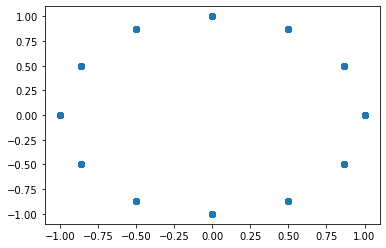

In [31]:
plt.scatter(all_d['MoSold_cos'].astype(np.floating), all_d['MoSold_sin'].astype(np.floating));

In [29]:
all_d['MoSold_sin'].dtype

dtype('float64')

In [30]:
'MoSold_sin' in numbers_col

False